In [1]:
from google.colab import drive 
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import altair as alt 
import os

In [3]:
ROOT = '/content/gdrive/MyDrive/Colab Notebooks/'
categories = pd.read_csv(ROOT + 'item_categories.csv')
items = pd.read_csv(ROOT + 'items.csv')
train = pd.read_csv(ROOT + 'sales_train.csv')
submission = pd.read_csv(ROOT + 'sample_submission.csv')
shops = pd.read_csv(ROOT + 'shops.csv')
test = pd.read_csv(ROOT + 'test.csv')

**Data Analysis and dealing Outliers**

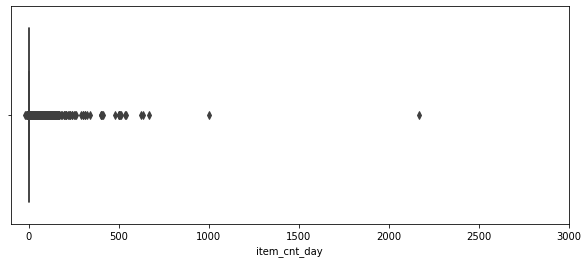

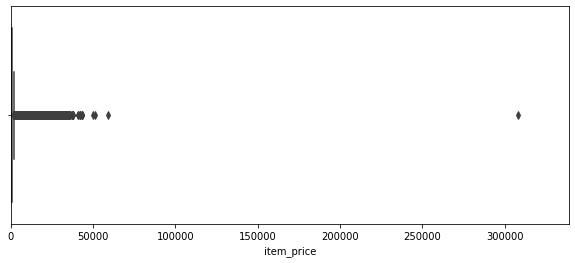

In [4]:
#Analysis price and item_cnt_day 
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [5]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1000]

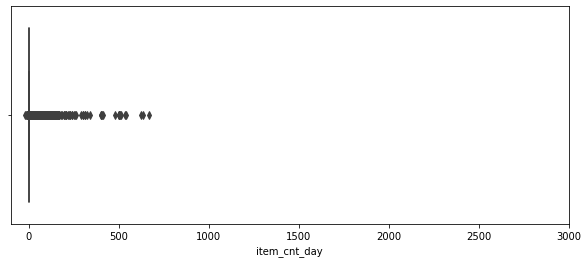

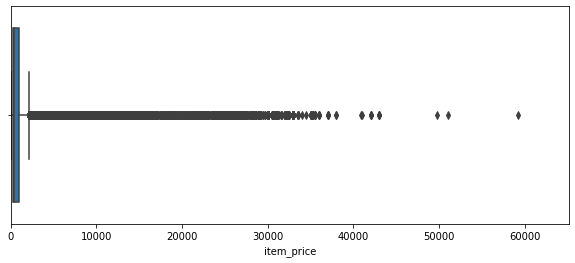

In [6]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [7]:
tmp = train[train.item_price<0]
tmp

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [8]:
med = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median() #price가 0보다 작은 데이터
train.loc[train.item_price<0, 'item_price'] = med
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [9]:
# delete duplicated data
col = ['date','date_block_num','shop_id','item_id','item_cnt_day']
print(train.duplicated(subset=col).value_counts())
train.drop_duplicates(subset=col, inplace=True)

False    2935822
True          24
dtype: int64


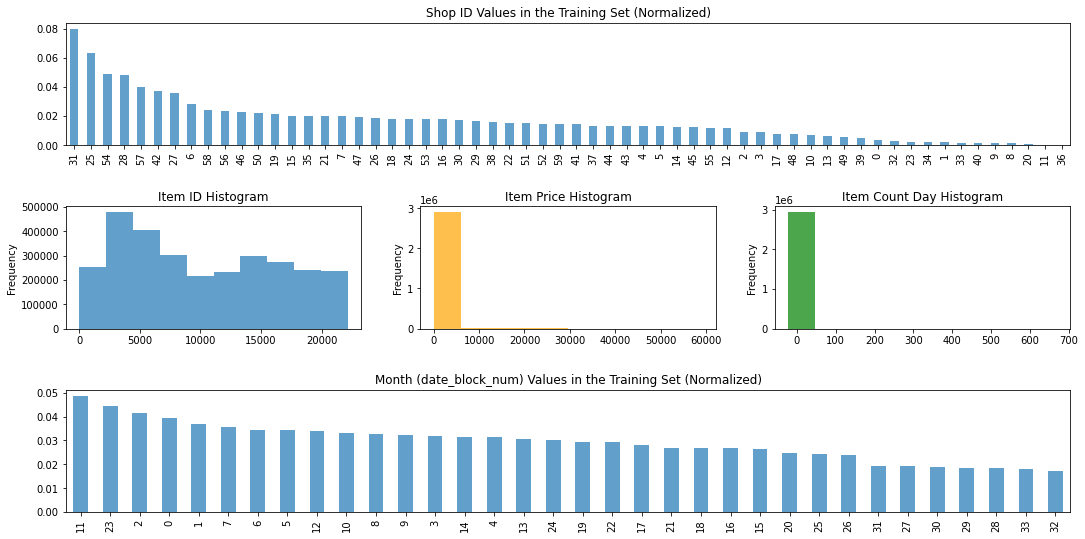

In [10]:
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
train['shop_id'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)
plt.title('Shop ID Values in the Training Set (Normalized)')

plt.subplot2grid((3,3), (1,0))
train['item_id'].plot(kind='hist', alpha=0.7)
plt.title('Item ID Histogram')

plt.subplot2grid((3,3), (1,1))
train['item_price'].plot(kind='hist', alpha=0.7, color='orange')
plt.title('Item Price Histogram')

plt.subplot2grid((3,3), (1,2))
train['item_cnt_day'].plot(kind='hist', alpha=0.7, color='green')
plt.title('Item Count Day Histogram')

plt.subplot2grid((3,3), (2,0), colspan = 3)
train['date_block_num'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)
plt.title('Month (date_block_num) Values in the Training Set (Normalized)')

plt.show()

Dealing with Outliers

In [11]:
train['item_id'].value_counts(ascending=False)[:5]

20949    31339
5822      9408
17717     9067
2808      7479
4181      6853
Name: item_id, dtype: int64

In [12]:
items.loc[items['item_id']==20949]

,item_name,item_id,item_category_id
20949,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71


In [13]:
train.loc[train['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 0, 'shop_id'] = 57

train.loc[train['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 1, 'shop_id'] = 58

train.loc[train['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 10, 'shop_id'] = 11

Extracting City


In [14]:
cities = shops['shop_name'].str.split(' ').map(lambda row: row[0])
cities.unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [15]:
shops['city'] = shops['shop_name'].str.split(' ').map(lambda row: row[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

In [16]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit_transform(shops['city'])

array([29, 29,  0,  1,  2,  3,  4,  4,  4,  5,  6,  6,  7,  8,  8,  9, 10,
       11, 11, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14,
       15, 15, 16, 16, 17, 18, 18, 18, 19, 19, 20, 20, 21, 22, 23, 24, 24,
       24, 25, 25, 26, 27, 28, 29, 29, 30])

In [17]:
shops['city_label'] = le.fit_transform(shops['city'])
shops.drop(['shop_name', 'city'], axis = 1, inplace = True)
shops.head()

,shop_id,city_label
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


Items Analysis

In [18]:
items_train = train['item_id'].nunique()
items_test = test['item_id'].nunique()
print('train Set: ', items_train)
print('test Set: ', items_test)

train Set:  21806
test Set:  5100


Check if all target items are in the train data

In [19]:
train_items = list(train['item_id'].unique())
test_items = list(test['item_id'].unique())

flag = 0
if(set(train_items).issubset(set(test_items))): 
    flag = 1
      
if (flag) : 
    print ("test included") 
else : 
    print ("not included") 

not included


In [20]:
len(set(test_items).difference(train_items))

363

In [21]:
categories_in_test = items.loc[items['item_id'].isin(sorted(test['item_id'].unique()))].item_category_id.unique()

In [22]:
categories.loc[~categories['item_category_id'].isin(categories_in_test)]

,item_category_name,item_category_id
1,Аксессуары - PS2,1
4,Аксессуары - PSP,4
8,Билеты (Цифра),8
10,Игровые консоли - PS2,10
13,Игровые консоли - PSP,13
14,Игровые консоли - PSVita,14
17,Игровые консоли - Прочие,17
18,Игры - PS2,18
32,"Карты оплаты (Кино, Музыка, Игры)",32
39,Кино - Blu-Ray 4K,39


Divide category into Main-category and Sub-category

In [23]:
le = preprocessing.LabelEncoder()

main_categories = categories['item_category_name'].str.split('-')
categories['main_category_id'] = main_categories.map(lambda row: row[0].strip())
categories['main_category_id'] = le.fit_transform(categories['main_category_id'])

# Some items don't have sub-categories. use the main category as a sub-category
categories['sub_category_id'] = main_categories.map(lambda row: row[1].strip() if len(row) > 1 else row[0].strip())
categories['sub_category_id'] = le.fit_transform(categories['sub_category_id'])

In [24]:
categories.head()

,item_category_name,item_category_id,main_category_id,sub_category_id
0,PC - Гарнитуры/Наушники,0,0,29
1,Аксессуары - PS2,1,1,9
2,Аксессуары - PS3,2,1,10
3,Аксессуары - PS4,3,1,11
4,Аксессуары - PSP,4,1,13


Generating product of Shop-Item pairs for each month in the training data


In [25]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [26]:
train['date'] =  pd.to_datetime(train['date'], format='%d.%m.%Y')

In [27]:
from itertools import product

In [28]:
from tqdm import tqdm_notebook

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols]   = df[int_cols].astype(np.int16)
    
    return df

In [29]:
cartesian = []
for month in range(0,34):
    shops_in_month = train.loc[train['date_block_num']==month, 'shop_id'].unique()
    items_in_month = train.loc[train['date_block_num']==month, 'item_id'].unique()
    cartesian.append(np.array(list(product(*[shops_in_month, items_in_month, [month]])), dtype='int32'))

In [30]:
cartesian_df = pd.DataFrame(np.vstack(cartesian), columns = ['shop_id', 'item_id', 'date_block_num'], dtype=np.int32)

In [31]:
cartesian_df.shape

(10913804, 3)

In [32]:
cartesian_df

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0
...,...,...,...
10913799,21,7635,33
10913800,21,7638,33
10913801,21,7640,33
10913802,21,7632,33


# Aggregating sales to a monthly level and clipping target variable

In [33]:
x = train.groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_day'].sum().rename('item_cnt_month').reset_index()
x.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,2,27,0,1.0
1,2,27,17,1.0
2,2,30,2,1.0
3,2,30,5,1.0
4,2,30,15,1.0


In [34]:
x.shape

(1609122, 4)

In [35]:
new_train = pd.merge(cartesian_df, x, on=['shop_id', 'item_id', 'date_block_num'], how='left').fillna(0)

In [36]:
new_train['item_cnt_month'] = np.clip(new_train['item_cnt_month'], 0, 20)

In [37]:
del test_items
del train_items
#del train

In [38]:
new_train.sort_values(['date_block_num','shop_id','item_id'], inplace = True)
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month
114910,2,19,0,0.0
117150,2,27,0,1.0
120623,2,28,0,0.0
118316,2,29,0,0.0
114602,2,32,0,0.0


Appending Test Set to Training Set

In [39]:
#test.insert(loc=3, column='date_block_num', value=34)
test['date_block_num']=34

In [40]:
test['item_cnt_month'] = 0

In [41]:
test.head()

,ID,shop_id,item_id,date_block_num,item_cnt_month
0,0,5,5037,34,0
1,1,5,5320,34,0
2,2,5,5233,34,0
3,3,5,5232,34,0
4,4,5,5268,34,0


In [42]:
new_train = new_train.append(test.drop('ID', axis = 1))

Merging Shops, Items, Categories dataframes to add the city label, category_id, main category and sub-category feature

In [43]:
new_train = pd.merge(new_train, shops, on=['shop_id'], how='left')
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_label
0,2,19,0,0.0,0
1,2,27,0,1.0,0
2,2,28,0,0.0,0
3,2,29,0,0.0,0
4,2,32,0,0.0,0


In [44]:
new_train = pd.merge(new_train, items.drop('item_name', axis = 1), on=['item_id'], how='left')
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_label,item_category_id
0,2,19,0,0.0,0,40
1,2,27,0,1.0,0,19
2,2,28,0,0.0,0,30
3,2,29,0,0.0,0,23
4,2,32,0,0.0,0,40


In [45]:
new_train = pd.merge(new_train, categories.drop('item_category_name', axis = 1), on=['item_category_id'], how='left')
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_label,item_category_id,main_category_id,sub_category_id
0,2,19,0,0.0,0,40,11,4
1,2,27,0,1.0,0,19,5,10
2,2,28,0,0.0,0,30,8,55
3,2,29,0,0.0,0,23,5,16
4,2,32,0,0.0,0,40,11,4


Generating Lag Features and Mean-Encodings

In [46]:
def generate_lag(train, months, lag_column):
    for month in months:
        # Speed up by grabbing only the useful bits
        train_shift = train[['date_block_num', 'shop_id', 'item_id', lag_column]].copy()
        train_shift.columns = ['date_block_num', 'shop_id', 'item_id', lag_column+'_lag_'+ str(month)]
        train_shift['date_block_num'] += month
        train = pd.merge(train, train_shift, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    return train

In [47]:
del items
del categories
del shops
#del test

In [48]:
new_train = downcast_dtypes(new_train)

In [49]:
import gc
gc.collect()

212

*Lag* for Item_cnt_month


In [50]:
%%time
new_train = generate_lag(new_train, [1,2,3,4,5,6,9,12], 'item_cnt_month')

CPU times: user 1min 8s, sys: 1.5 s, total: 1min 10s
Wall time: 1min 9s


In [51]:
new_train

,shop_id,item_id,date_block_num,item_cnt_month,city_label,item_category_id,main_category_id,sub_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_9,item_cnt_month_lag_12
0,2,19,0,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,27,0,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,28,0,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,29,0,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,32,0,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,45,18454,34,0.0,20,55,13,2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
11128000,45,16188,34,0.0,20,64,14,42,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
11128001,45,15757,34,0.0,20,55,13,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11128002,45,19648,34,0.0,20,40,11,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


Lag for Lag for Item_cnt_month mean


In [52]:
%%time
group = new_train.groupby(['date_block_num', 'item_id'])['item_cnt_month'].mean().rename('item_month_mean').reset_index()
new_train = pd.merge(new_train, group, on=['date_block_num', 'item_id'], how='left')
new_train = generate_lag(new_train, [1,2,3,6,9,12], 'item_month_mean')
new_train.drop(['item_month_mean'], axis=1, inplace=True)
new_train.head()

CPU times: user 1min 5s, sys: 1.51 s, total: 1min 6s
Wall time: 1min 6s


Lag for monthly Shop-Category mean

In [53]:
%%time
group = new_train.groupby(['date_block_num', 'shop_id', 'item_category_id'])['item_cnt_month'].mean().rename('shop_category_month_mean').reset_index()
new_train = pd.merge(new_train, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
new_train = generate_lag(new_train, [1, 2], 'shop_category_month_mean')
new_train.drop(['shop_category_month_mean'], axis=1, inplace=True)

CPU times: user 26.3 s, sys: 452 ms, total: 26.8 s
Wall time: 26.6 s


In [54]:
new_train.tail()

,shop_id,item_id,date_block_num,item_cnt_month,city_label,item_category_id,main_category_id,sub_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_9,item_cnt_month_lag_12,item_month_mean_lag_1,item_month_mean_lag_2,item_month_mean_lag_3,item_month_mean_lag_6,item_month_mean_lag_9,item_month_mean_lag_12,shop_category_month_mean_lag_1,shop_category_month_mean_lag_2
11127999,45,18454,34,0.0,20,55,13,2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.045441,0.023254,0.071411,0.590820,2.000000,NaN,0.126831,0.074524
11128000,45,16188,34,0.0,20,64,14,42,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.022720,0.069763,NaN,NaN,NaN,NaN,0.094482,0.117126
11128001,45,15757,34,0.0,20,55,13,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.113647,0.069763,0.095215,0.250000,0.255371,0.180054,0.126831,0.074524
11128002,45,19648,34,0.0,20,40,11,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.045441,0.069763,0.166626,0.090881,0.085083,NaN,0.083740,0.074097
11128003,45,969,34,0.0,20,37,11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068176,0.116272,0.023804,0.068176,0.148926,0.119995,0.128174,0.067444


Lag for Monthly Main-Category mean

In [55]:
%%time
group = new_train.groupby(['date_block_num', 'main_category_id'])['item_cnt_month'].mean().rename('main_category_month_mean').reset_index()
new_train = pd.merge(new_train, group, on=['date_block_num', 'main_category_id'], how='left')

new_train = generate_lag(new_train, [1], 'main_category_month_mean')
new_train.drop(['main_category_month_mean'], axis=1, inplace=True)

CPU times: user 16.1 s, sys: 445 ms, total: 16.5 s
Wall time: 16.4 s


Lag for Monthly Sub-Category mean

In [56]:
%%time
group = new_train.groupby(['date_block_num', 'sub_category_id'])['item_cnt_month'].mean().rename('sub_category_month_mean').reset_index()
new_train = pd.merge(new_train, group, on=['date_block_num', 'sub_category_id'], how='left')

new_train = generate_lag(new_train, [1], 'sub_category_month_mean')
new_train.drop(['sub_category_month_mean'], axis=1, inplace=True)

CPU times: user 16.6 s, sys: 432 ms, total: 17 s
Wall time: 16.9 s


In [57]:
new_train.tail()

,shop_id,item_id,date_block_num,item_cnt_month,city_label,item_category_id,main_category_id,sub_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_9,item_cnt_month_lag_12,item_month_mean_lag_1,item_month_mean_lag_2,item_month_mean_lag_3,item_month_mean_lag_6,item_month_mean_lag_9,item_month_mean_lag_12,shop_category_month_mean_lag_1,shop_category_month_mean_lag_2,main_category_month_mean_lag_1,sub_category_month_mean_lag_1
11127999,45,18454,34,0.0,20,55,13,2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.045441,0.023254,0.071411,0.590820,2.000000,NaN,0.126831,0.074524,0.146973,0.196899
11128000,45,16188,34,0.0,20,64,14,42,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.022720,0.069763,NaN,NaN,NaN,NaN,0.094482,0.117126,0.237305,0.155884
11128001,45,15757,34,0.0,20,55,13,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.113647,0.069763,0.095215,0.250000,0.255371,0.180054,0.126831,0.074524,0.146973,0.196899
11128002,45,19648,34,0.0,20,40,11,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.045441,0.069763,0.166626,0.090881,0.085083,NaN,0.083740,0.074097,0.224243,0.220825
11128003,45,969,34,0.0,20,37,11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068176,0.116272,0.023804,0.068176,0.148926,0.119995,0.128174,0.067444,0.224243,0.240845


Price Trend

In [58]:
# average price of items in the entire period
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(new_train, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

# monthly
group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

# lag for 6months
lags = [1,2,3,4,5,6]
matrix =generate_lag(matrix, lags, 'date_item_avg_item_price')

# make 6 lag trends
for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

# choose the most recent trend
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# drop not used feature
fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

In [59]:
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_label,item_category_id,main_category_id,sub_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_9,item_cnt_month_lag_12,item_month_mean_lag_1,item_month_mean_lag_2,item_month_mean_lag_3,item_month_mean_lag_6,item_month_mean_lag_9,item_month_mean_lag_12,shop_category_month_mean_lag_1,shop_category_month_mean_lag_2,main_category_month_mean_lag_1,sub_category_month_mean_lag_1,delta_price_lag
0,2,19,0,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2,27,0,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,2,28,0,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,2,29,0,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,2,32,0,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


Shop revenue Trend

In [60]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [61]:
# monthly
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

# average revenue of shops in the entire period
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

# make trends
matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

# choose the most recent trend
matrix = generate_lag(matrix, [1], 'delta_revenue')

# drop not used features
matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

Last sold month

In [62]:

cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)

# get last sold month for each item
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num > last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num 
            

In [63]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

In [64]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

Add month feature!

In [65]:
matrix['month'] = matrix['date_block_num'] % 12

Add Holiday feature!

In [66]:
holiday_dict = {
    0: 6,
    1: 3,
    2: 2,
    3: 8,
    4: 3,
    5: 3,
    6: 2,
    7: 8,
    8: 4,
    9: 8,
    10: 5,
    11: 4,
}

In [67]:
matrix['holidays_in_month'] = matrix['month'].map(holiday_dict)

cpi value

---



---




In [68]:
cpi = {
    
    12: 408.3, 13: 411.2, 14: 415.3,
    15: 419.1, 16: 422.8, 17: 425.5,
    18: 427.5, 19: 428.6, 20: 431.4,
    21: 434.9, 22: 440.5, 23: 452,
    24: 469.4, 25: 479.8, 26: 485.6,
    27: 487.8, 28: 489.5, 29: 490.5,
    30: 494.4, 31: 496.1, 32: 499,
    33: 502.7, 34: 506.4,


}

In [69]:
matrix['cpi_value'] = matrix.date_block_num.map(cpi)

In [70]:
matrix = downcast_dtypes(matrix)

In [71]:
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_label,item_category_id,main_category_id,sub_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_9,item_cnt_month_lag_12,item_month_mean_lag_1,item_month_mean_lag_2,item_month_mean_lag_3,item_month_mean_lag_6,item_month_mean_lag_9,item_month_mean_lag_12,shop_category_month_mean_lag_1,shop_category_month_mean_lag_2,main_category_month_mean_lag_1,sub_category_month_mean_lag_1,delta_price_lag,delta_revenue_lag_1,item_last_sale,item_shop_first_sale,item_first_sale,month,holidays_in_month,cpi_value
0,2,19,0,0.0,0,40,11,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,-1,0,0,0,6,NaN
1,2,27,0,1.0,0,19,5,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,-1,0,0,0,6,NaN
2,2,28,0,0.0,0,30,8,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,-1,0,0,0,6,NaN
3,2,29,0,0.0,0,23,5,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,-1,0,0,0,6,NaN
4,2,32,0,0.0,0,40,11,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,-1,0,0,0,6,NaN


In [72]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [73]:
matrix

,shop_id,item_id,date_block_num,item_cnt_month,city_label,item_category_id,main_category_id,sub_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_9,item_cnt_month_lag_12,item_month_mean_lag_1,item_month_mean_lag_2,item_month_mean_lag_3,item_month_mean_lag_6,item_month_mean_lag_9,item_month_mean_lag_12,shop_category_month_mean_lag_1,shop_category_month_mean_lag_2,main_category_month_mean_lag_1,sub_category_month_mean_lag_1,delta_price_lag,delta_revenue_lag_1,item_last_sale,item_shop_first_sale,item_first_sale,month,holidays_in_month,cpi_value,days
0,2,19,0,0.0,0,40,11,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,-1,0,0,0,6,NaN,31
1,2,27,0,1.0,0,19,5,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,-1,0,0,0,6,NaN,31
2,2,28,0,0.0,0,30,8,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,-1,0,0,0,6,NaN,31
3,2,29,0,0.0,0,23,5,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,-1,0,0,0,6,NaN,31
4,2,32,0,0.0,0,40,11,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,-1,0,0,0,6,NaN,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,45,18454,34,0.0,20,55,13,2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.045441,0.023254,0.071411,0.590820,2.000000,NaN,0.126831,0.074524,0.146973,0.196899,-0.475098,-0.290039,-1,11,11,10,5,506.5,30
11128000,45,16188,34,0.0,20,64,14,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022720,0.069763,NaN,NaN,NaN,NaN,0.094482,0.117126,0.237305,0.155884,0.081116,-0.290039,-1,2,2,10,5,506.5,30
11128001,45,15757,34,0.0,20,55,13,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.113647,0.069763,0.095215,0.250000,0.255371,0.180054,0.126831,0.074524,0.146973,0.196899,0.155884,-0.290039,-1,34,34,10,5,506.5,30
11128002,45,19648,34,0.0,20,40,11,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045441,0.069763,0.166626,0.090881,0.085083,NaN,0.083740,0.074097,0.224243,0.220825,-0.091736,-0.290039,-1,11,11,10,5,506.5,30


In [74]:
del new_train
gc.collect()

50

MAKE TRAINING SET & TRAIN ! 

In [75]:
X_train = matrix[(matrix.date_block_num >11) & (matrix.date_block_num < 33)].drop(['item_cnt_month'], axis=1)
Y_train = matrix[(matrix.date_block_num >11) & (matrix.date_block_num < 33)]['item_cnt_month']
X_valid = matrix[matrix.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = matrix[matrix.date_block_num == 33]['item_cnt_month']
X_test = matrix[matrix.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [76]:
X_train.head()

,shop_id,item_id,date_block_num,city_label,item_category_id,main_category_id,sub_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_9,item_cnt_month_lag_12,item_month_mean_lag_1,item_month_mean_lag_2,item_month_mean_lag_3,item_month_mean_lag_6,item_month_mean_lag_9,item_month_mean_lag_12,shop_category_month_mean_lag_1,shop_category_month_mean_lag_2,main_category_month_mean_lag_1,sub_category_month_mean_lag_1,delta_price_lag,delta_revenue_lag_1,item_last_sale,item_shop_first_sale,item_first_sale,month,holidays_in_month,cpi_value,days
4488710,2,27,12,0,19,5,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.086975,0.044434,0.130493,0.065247,0.021744,0.155518,0.955566,0.571289,1.03418,1.075195,-0.282715,1.211914,1,12,12,0,6,408.25,31
4488711,2,30,12,0,40,11,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.021484,1.022461,0.521973,0.891113,2.826172,NaN,0.046234,0.022934,0.27002,0.291504,-0.483398,1.211914,1,11,11,0,6,408.25,31
4488712,2,31,12,0,37,11,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.543457,0.600098,0.543457,0.304443,1.260742,NaN,0.059448,0.046814,0.27002,0.234009,-0.137451,1.211914,1,11,11,0,6,408.25,31
4488713,2,32,12,0,40,11,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.934570,1.799805,1.260742,1.891602,2.109375,5.378906,0.046234,0.022934,0.27002,0.291504,-0.407227,1.211914,1,12,12,0,6,408.25,31
4488714,2,33,12,0,37,11,1,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.913086,0.333252,0.717285,1.000000,0.347900,1.355469,0.059448,0.046814,0.27002,0.234009,-0.225464,1.211914,1,12,12,0,6,408.25,31


Training

In [77]:
feature_name=X_train.columns.tolist()

In [78]:
from sklearn import linear_model, preprocessing
from sklearn.model_selection import GroupKFold
import lightgbm as lgb

params={'learning_rate': 0.01,
        'objective':'mse',
        'metric':'rmse',
        'num_leaves': 120,
        'verbose': 1,
        'random_state':42,
        'bagging_fraction': 0.75,
        'feature_fraction': 0.75,
        'bagging_freq':5
        
       }
lgb_train=lgb.Dataset(X_train[feature_name],Y_train)
lgb_eval = lgb.Dataset(X_valid[feature_name], Y_valid, reference=lgb_train)

evals_result = {}
gbm = lgb.train(
        params, 
        lgb_train,
        num_boost_round=3000,
        valid_sets=(lgb_train, lgb_eval), 
        feature_name = feature_name,
        verbose_eval=5, 
        evals_result = evals_result)


[5]	training's rmse: 1.16208	valid_1's rmse: 1.11787
[10]	training's rmse: 1.13857	valid_1's rmse: 1.10075
[15]	training's rmse: 1.11524	valid_1's rmse: 1.08467
[20]	training's rmse: 1.09385	valid_1's rmse: 1.07011
[25]	training's rmse: 1.07362	valid_1's rmse: 1.05661
[30]	training's rmse: 1.05495	valid_1's rmse: 1.04388
[35]	training's rmse: 1.03747	valid_1's rmse: 1.03297
[40]	training's rmse: 1.02188	valid_1's rmse: 1.02313
[45]	training's rmse: 1.00684	valid_1's rmse: 1.01412
[50]	training's rmse: 0.993093	valid_1's rmse: 1.00574
[55]	training's rmse: 0.98027	valid_1's rmse: 0.997929
[60]	training's rmse: 0.967871	valid_1's rmse: 0.99109
[65]	training's rmse: 0.956456	valid_1's rmse: 0.984992
[70]	training's rmse: 0.946195	valid_1's rmse: 0.978829
[75]	training's rmse: 0.936592	valid_1's rmse: 0.974228
[80]	training's rmse: 0.927853	valid_1's rmse: 0.970222
[85]	training's rmse: 0.919312	valid_1's rmse: 0.96721
[90]	training's rmse: 0.911625	valid_1's rmse: 0.963592
[95]	training's

In [79]:

Y_test = gbm.predict(X_test[feature_name]).clip(0, 20)
result = pd.DataFrame({
    "ID": test["ID"],
    "item_cnt_month": Y_test
})
result.to_csv("submission.csv", index=False)

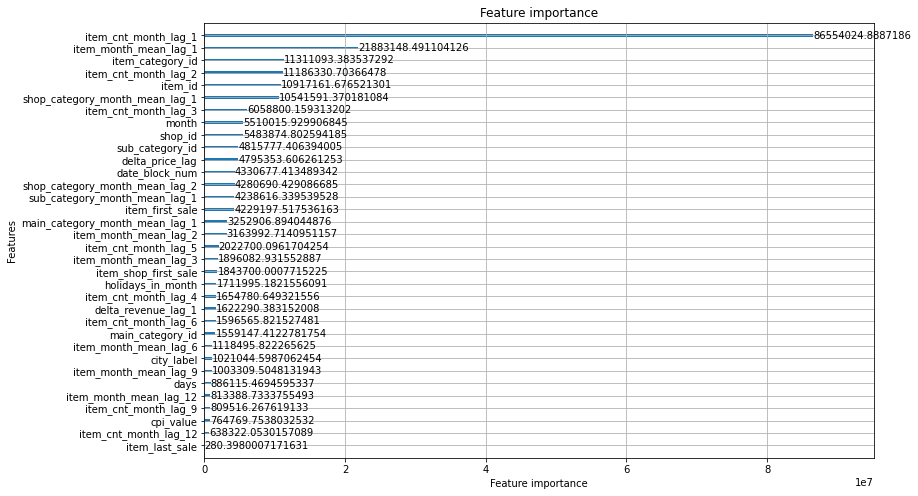

In [80]:
lgb.plot_importance(
    gbm, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,8));